In [1]:
!pip install textstat -q
!pip install language_tool_python -q
!pip install gdown==4.6.0 -q
!pip install eli5 -q

import eli5
import spacy
import pandas as pd
import numpy as np
import csv
import nltk
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textstat.textstat import textstat
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter
from sklearn.utils import shuffle
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
nltk.download("wordnet")
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
!gdown 19A2fo1v2jTe3k2vQ4hWiXHdizn3KYdgw
!gdown 1Dw3QSY4NCpbcsp6maUC06wAMk31_SzKW

Downloading...
From: https://drive.google.com/uc?id=19A2fo1v2jTe3k2vQ4hWiXHdizn3KYdgw
To: /content/Chat gpt - reviews.txt
100% 212k/212k [00:00<00:00, 5.41MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Dw3QSY4NCpbcsp6maUC06wAMk31_SzKW
To: /content/hotel_reviews.csv
100% 1.33M/1.33M [00:00<00:00, 10.7MB/s]


# Creating dataframes

# Data frames containing the Machine Generated reviews

In [48]:
training = []
evaluation = []

# Read the text file line by line
with open('Chat gpt - reviews.txt', 'r') as file:
    pos_neg = "pos"
    current_reviews = []
    for line in file:
        line = line.strip()
        if line == "---Negative Reviews---":
            pos_neg = "neg"
            continue
        if line:
            current_reviews.append((line, pos_neg))

positive_count = 0
negative_count = 0

for review, label in current_reviews:
    if label == "pos" and positive_count < 160:
        training.append((review, label))
        positive_count += 1
    elif label == "neg" and negative_count < 160:
        training.append((review, label))
        negative_count += 1
    else:
        evaluation.append((review, label))

training_df = pd.DataFrame(training, columns=['review_text', 'pos_neg'])
training_df['label'] = 0
training_df['generation'] = 'ChatGPT'

# Create a DataFrame for the remaining reviews
evaluation_df_MG = pd.DataFrame(evaluation, columns=['review_text', 'pos_neg'])
evaluation_df_MG ['label'] = 0
evaluation_df_MG['generation'] = 'ChatGPT'


In [49]:
evaluation_df_MG

,review_text,pos_neg,label,generation
0,Looby is where the magic begins in this hotel;...,pos,0,ChatGPT
1,"Trumping all my previous hotel experiences, th...",pos,0,ChatGPT
2,"Ship-shape and brimming with style, this hotel...",pos,0,ChatGPT
3,"Butter-smooth service, that's what I experienc...",pos,0,ChatGPT
4,"Soho's charm blew me away, especially the magn...",pos,0,ChatGPT
...,...,...,...,...
75,"Luckily, I'm a seasoned traveler, so I've seen...",neg,0,ChatGPT
76,"Teenager-infested, this hotel negatively impac...",neg,0,ChatGPT
77,Implying that their establishment was a high-e...,neg,0,ChatGPT
78,Set in what could have been an idyllic locatio...,neg,0,ChatGPT


In [50]:
training_df

,review_text,pos_neg,label,generation
0,"Blu, the color of the serene sea, was the them...",pos,0,ChatGPT
1,Disabled-friendly facilities can often be a hi...,pos,0,ChatGPT
2,"Location wise, the hotel is an absolute gem, n...",pos,0,ChatGPT
3,"220 times over, I would recommend this hotel t...",pos,0,ChatGPT
4,Accommodations at the Grand Royale Hotel surpa...,pos,0,ChatGPT
...,...,...,...,...
315,"Bag in hand, I trudged through the dimly lit, ...",neg,0,ChatGPT
316,"Sure, the hotel promised a four-diamond experi...",neg,0,ChatGPT
317,Strain was the first word that came to mind wh...,neg,0,ChatGPT
318,"""Scraps"" is the best word to describe the dism...",neg,0,ChatGPT


## Creating the full training dataset 3
We have available 800 Human Generated real ones, 400 Machine Generated  fake ones and 400 Human Generated fake.
We will do 80% (1280 samples) training with cross evalution as a development set and 20% (320 samples - 10 % in each condition) as a hold-out evaluation on first MG generated and then HG to see how well a model trained on both will generalize on unseen data.

* 640 real HG with 320 positive & 320 negative
* 320 fake HG with 160 positive & 160 negative
* 320 fake GPT with 160 positive & 160 negative

In [8]:
df_hotel = pd.read_csv('hotel_reviews.csv')
df_hotel = df_hotel.drop(columns=['ID'])
df_hotel["generation"] = "human"

real_human_reviews_pos = df_hotel[(df_hotel['label'] == 1) & (df_hotel['pos_neg'] == "pos")]
real_human_reviews_neg = df_hotel[(df_hotel['label'] == 1) & (df_hotel['pos_neg'] == "neg")]

fake_human_reviews_pos = df_hotel[(df_hotel['label'] == 0) & (df_hotel['pos_neg'] == "pos")]
fake_human_reviews_neg = df_hotel[(df_hotel['label'] == 0) & (df_hotel['pos_neg'] == "neg")]

In [51]:
# Take the first 160 rows from fake_human_reviews_pos and fake_human_reviews_neg
first_160_fake_pos = fake_human_reviews_pos.head(160)
first_160_fake_neg = fake_human_reviews_neg.head(160)

# Take the first 320 rows from real_human_reviews_pos and real_human_reviews_neg
first_320_real_pos = real_human_reviews_pos.head(320)
first_320_real_neg = real_human_reviews_neg.head(320)

# Concatenate them all into full_train_df with training_df (wthich comes from GPT)
full_train_df = pd.concat([training_df, first_160_fake_pos, first_160_fake_neg, first_320_real_pos, first_320_real_neg])
full_train_df = full_train_df.reset_index(drop=True)

In [52]:
full_train_df = shuffle(full_train_df, random_state=42)

In [53]:
full_train_df

,review_text,pos_neg,label,generation
1240,My wife and I just spent a long weekend at the...,neg,1,human
695,"Hi,Stayed here for three nights recently,From ...",pos,1,human
899,We wanted a nice place to stay the night after...,pos,1,human
770,After reading some of the most recent reviews ...,pos,1,human
743,We stayed at Omni Chicago for 2 nights in earl...,pos,1,human
...,...,...,...,...
1044,We stayed here because of the enthusiastic pos...,neg,1,human
1095,"Elegant lobby, comfy beds, nice sheets but, we...",neg,1,human
1130,I travel often for business and this hotel ran...,neg,1,human
860,"Great beds, clean rooms, amazing bathroom, nif...",pos,1,human


## Creating dataset evaluate 1
* 80 real HG
* 80 fake GPT

In [56]:
middle_real_pos = real_human_reviews_pos.iloc[320:360]
middle_real_neg = real_human_reviews_neg.iloc[320:360]

evaluate_1_mix = pd.concat([middle_real_pos, middle_real_neg ,evaluation_df_MG])
evaluate_1_mix = evaluate_1_mix.reset_index(drop=True)

## Creating dataset evaluate 2
* 80 real HG
* 80 fake HG

In [57]:
last_real_pos = real_human_reviews_pos.iloc[360:400]
last_real_neg = real_human_reviews_neg.iloc[360:400]

last_fake_pos = fake_human_reviews_pos.iloc[360:400]
last_fake_neg = fake_human_reviews_neg.iloc[360:400]

evaluate_2_HG = pd.concat([last_real_pos, last_real_neg ,last_fake_pos,last_fake_neg ])
evaluate_2_HG = evaluate_2_HG.reset_index(drop=True)

In [58]:
evaluate_2_HG

,label,pos_neg,review_text,generation
0,1,pos,Just back from a business trip. The Homewood i...,human
1,1,pos,My company booked our group for a Conference a...,human
2,1,pos,Striking architecture is only the beginning of...,human
3,1,pos,My husband and I wanted to spend the weekend i...,human
4,1,pos,I booked this hotel for $75 on Hotwire with mi...,human
...,...,...,...,...
155,0,neg,A friend and I stayed at the Hyatt Regency in ...,human
156,0,neg,"Though grand and having a brand, this hotel se...",human
157,0,neg,When my husband and I went to Amalfi Hotel we ...,human
158,0,neg,A few weeks ago we stayed at the Hard Rock Hot...,human


#  Creating X and y


In [59]:
y = full_train_df["label"]
X = full_train_df["review_text"]

# Function to extract features

In [104]:
# NLP model for Named Entity Recognition (NER)
nlp = spacy.load("en_core_web_sm")
sia = SentimentIntensityAnalyzer()

def count_words_and_pos(text):
    tokens = nltk.word_tokenize(text)
    tagged = nltk.pos_tag(tokens)

    # Define POS tags for content and function words
    content_pos = {'NN', 'NNS', 'NNP', 'NNPS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS'}
    function_pos = {'IN', 'PRP', 'PRP$', 'DT', 'CC', 'MD'}

    # Counters
    content_count = 0
    function_count = 0
    pos_counts = Counter()

    for word, pos in tagged:
        if pos in content_pos:
            content_count += 1
        elif pos in function_pos:
            function_count += 1
        pos_counts[pos] += 1

    return content_count, function_count, pos_counts

# Custom transformer for counting content, function words, and specific POS
class Content_Extractor(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, texts):
        counts = [count_words_and_pos(text) for text in texts]
        content_counts, function_counts, pos_counts_list = zip(*counts)

        return np.array(content_counts).reshape(-1, 1)

class TfidfBigramVectorizer(TfidfVectorizer):
    def __init__(self, **kwargs):
        super(TfidfBigramVectorizer, self).__init__(ngram_range=(2, 2), **kwargs)

class NerExtractor(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, texts):
        ner_counts = []
        for doc in nlp.pipe(texts, disable=["parser"]):
            entities = [ent.label_ for ent in doc.ents]
            ner_counts.append(len(entities))
        return np.array(ner_counts).reshape(-1, 1)

class DigitCountExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, texts):
        digit_counts = [sum(c.isdigit() for c in text) for text in texts]
        return np.array(digit_counts).reshape(-1, 1)

# SentimentAnalysis implementation
class SentimentScoreExtractor(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, texts):
        vader_scores = [sia.polarity_scores(text) for text in texts]
        compound_scores = [score['compound'] for score in vader_scores]
        return np.array(compound_scores).reshape(-1, 1)


# function to count punctuation within the reviews
class PunctuationCounterExtractor(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, texts):
        punctuation = ['.', ',', '!', '?', '\'', '\\', '\"', '(', ')', ';', ':']
        punctuation_counts = []
        for text in texts:
            count = sum(1 for char in text if char in punctuation)
            punctuation_counts.append(count)
        return np.array(punctuation_counts).reshape(-1, 1)

# function to count capitalized letters within the reviews
class CapitalizationExtractor(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, texts):
        caps_counts = []

        for text in texts:
            caps_count = sum(1 for character in text if character.isupper())
            caps_counts.append(caps_count)

        return np.array(caps_counts).reshape(-1, 1)

#Flesch Readability Score as feature
class FleschReadabilityExtractor(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, texts):
        readability_scores = [textstat.flesch_reading_ease(text) for text in texts]
        return np.array(readability_scores).reshape(-1, 1)

# Models & Evaluation

## Pipeline builder

In [61]:
def build_custom_pipeline(classifier, features):
    pipeline = Pipeline([
        ('features', features),
        ('scale', StandardScaler(with_mean=False)),
        ('classifier', classifier)
    ])
    return pipeline

combined_features = FeatureUnion([
    ('ner_feature', NerExtractor()),
    ('tfidf_bigram', TfidfBigramVectorizer()),
    ('sentiment_score', SentimentScoreExtractor()),
    ('punct_count', PunctuationCounterExtractor()),
    ('content_count', Content_Extractor()),
    ('flesch', FleschReadabilityExtractor()),
    ('cap_count', CapitalizationExtractor()),
])

# Logistic Regression

In [62]:
classifier = LogisticRegression()
pipeline_log = build_custom_pipeline(classifier, combined_features)

# Fit the pipeline on the training data - not necessary for k fold cross validation
#pipeline_log.fit(X_train["review_text"], y_train)

### Score on 5 fold cross validation for LR for mixed full data set

In [63]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform K-Fold cross validation on the entire dataset
scores = cross_val_score(pipeline_log, X, y, cv=kfold, scoring='accuracy')

# Print the average score
print("Cross-validation scores:", scores)
print(f'Average Score: {np.mean(scores)}')

Cross-validation scores: [0.8828125  0.83984375 0.8671875  0.8359375  0.88671875]
Average Score: 0.8625


## LR on evaluate 1 (80 real & 80 GPT)

In [64]:
y_ev1 = evaluate_1_mix["label"]
X_ev1 = evaluate_1_mix["review_text"]

In [65]:
pipeline_log.fit(X, y)
predictions = pipeline_log.predict(X_ev1)
accuracy = accuracy_score(y_ev1, predictions)
print(f'Accuracy on Single Dataset Evaluation for computer generated: {accuracy}')


Accuracy on Single Dataset Evaluation for computer generated: 0.95625


## Examples of Wrong Predictions

In [81]:
predictions = pipeline_log.predict(X_ev1)

# Calculate accuracy
accuracy = accuracy_score(y_ev1, predictions)
print(f'Accuracy on Single Dataset Evaluation for computer-generated: {accuracy}')

# Find instances where the model's predictions are wrong
wrong_predictions = [(text, actual, predicted) for text, actual, predicted in zip(X_ev1, y_ev1, predictions) if actual != predicted]

# Print out the instances where the model is wrong
for text, actual, predicted in wrong_predictions:
    print(f'Text: {text}')
    print(f'Actual Label: {actual}')
    print(f'Predicted Label: {predicted}')
    print('---')


Accuracy on Single Dataset Evaluation for computer-generated: 0.95625
Text: I loved the Ambassador! What a great hotel. It's really beautiful, and the room was absolutely striking, very classic and elegant. Everything was done really well: the staff treated me like a regular. This is a top-notch hotel, the best place I've stayed in a long time. My only complaint is that I wish it was on the Mile, but that's it. 

Actual Label: 1
Predicted Label: 0
---
Text: A friend highly recommended this hotel and we couldn't have been happier! It was wonderful ~ my husband and kids were already planning our next trip there before we had even left the hotel. The kids loved the goldfish in the room and thought the window seats were the best. 

Actual Label: 1
Predicted Label: 0
---
Text: My boyfriend and I were amazed by the breathtaking view of Lake Michigan! We are from Texas so the view of the city was very important to us. We had no problems at this hotel... rooms, service, location were top notch

## LR on Evaluate 2 (80 real HG & 80 fake HG)

In [66]:
y_ev2 = evaluate_2_HG["label"]
X_ev2 = evaluate_2_HG["review_text"]

In [67]:
# Choose one dataset for final evaluation (e.g., human-written)
pipeline_log.fit(X, y)
predictions = pipeline_log.predict(X_ev2)
accuracy = accuracy_score(y_ev2, predictions)
print(f'Accuracy on Single Dataset Evaluation with only Human Generated: {accuracy}')


Accuracy on Single Dataset Evaluation with only Human Generated: 0.825


# SVM

In [68]:
classifier = LinearSVC(C=1.0) #max_iter=1000)
pipeline_linear_SVC = build_custom_pipeline(classifier, combined_features)

In [69]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform K-Fold cross-validation
scores = cross_val_score(pipeline_linear_SVC, X, y, cv=kfold, scoring='accuracy')

# Print the scores and the average score
print("Cross-validation scores:", scores)
print(f'Average Score: {np.mean(scores):.4f}')

Cross-validation scores: [0.890625   0.84375    0.87109375 0.84375    0.88671875]
Average Score: 0.8672


## SVM on evaluate 1 (80 real HG & 80 GPT)

In [70]:
pipeline_linear_SVC.fit(X, y)
predictions = pipeline_linear_SVC.predict(X_ev1)
accuracy = accuracy_score(y_ev1, predictions)
print(f'Accuracy on Single Dataset Evaluation with on machine generated: {accuracy}')


Accuracy on Single Dataset Evaluation with a mix: 0.95625


##SVM on Evaluate 2 (80 real HG & 80 fake HG)

In [71]:
predictions = pipeline_linear_SVC.predict(X_ev2)
accuracy = accuracy_score(y_ev2, predictions)
print(f'Accuracy on Single Dataset Evaluation with only Human Generated: {accuracy}')


Accuracy on Single Dataset Evaluation with only Human Generated: 0.81875


# AdaBoost

In [72]:
sgd_hinge = SGDClassifier(loss="hinge")

pipeline_with_adaboost_samme = Pipeline([
    ('features', combined_features),
    ('scale', StandardScaler(with_mean=False)),
    ('classifier', AdaBoostClassifier(
        estimator=sgd_hinge,
        n_estimators=50,
        learning_rate=1.0,
        algorithm='SAMME'
    ))
])

# Fit and use the pipelines if needed
#pipeline_with_adaboost_samme.fit(X_train["review_text"], y_train)

In [73]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform K-Fold cross-validation
scores = cross_val_score(pipeline_with_adaboost_samme, X, y, cv=kfold, scoring='accuracy')

# Print the scores and the average score
print("Cross-validation scores:", scores)
print(f'Average Score: {np.mean(scores):.4f}')


Cross-validation scores: [0.8046875  0.8046875  0.81640625 0.8125     0.828125  ]
Average Score: 0.8133


## AdaBoost on evaluate 1 (80 real HG & 80 GPT)

In [74]:
pipeline_with_adaboost_samme.fit(X, y)
predictions = pipeline_with_adaboost_samme.predict(X_ev1)
accuracy = accuracy_score(y_ev1, predictions)
print(f'Accuracy on Single Dataset Evaluation with on machine generated: {accuracy}')

Accuracy on Single Dataset Evaluation with on machine generated: 0.875


##AdaBoost on Evaluate 2 (80 real HG & 80 fake HG)

In [75]:
predictions = pipeline_with_adaboost_samme.predict(X_ev2)
accuracy = accuracy_score(y_ev2, predictions)
print(f'Accuracy on Single Dataset Evaluation with only Human Generated: {accuracy}')


Accuracy on Single Dataset Evaluation with only Human Generated: 0.73125


# Random Forest

In [76]:
classifier = RandomForestClassifier() #(n_estimators=100)
pipeline_rdn = build_custom_pipeline(classifier, combined_features)

# Fit the pipeline on the training data - not for k fold cross
#pipeline_rdn.fit(X_train["review_text"], y_train)

In [77]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform K-Fold cross-validation
scores = cross_val_score(pipeline_rdn, X, y, cv=kfold, scoring='accuracy')

# Print the scores and the average score
print("Cross-validation scores:", scores)
print(f'Average Score: {np.mean(scores):.4f}')


Cross-validation scores: [0.84765625 0.8125     0.8359375  0.8125     0.83203125]
Average Score: 0.8281


## Random Forest on evaluate 1 (80 real HG & 80 GPT)

In [78]:
pipeline_rdn.fit(X, y)
predictions = pipeline_rdn.predict(X_ev1)
accuracy = accuracy_score(y_ev1, predictions)
print(f'Accuracy on Single Dataset Evaluation with on machine generated: {accuracy}')

Accuracy on Single Dataset Evaluation with on machine generated: 0.925


##Random Forest on Evaluate 2 (80 real HG & 80 fake HG)

In [79]:
predictions = pipeline_rdn.predict(X_ev2)
accuracy = accuracy_score(y_ev2, predictions)
print(f'Accuracy on Single Dataset Evaluation with only Human Generated: {accuracy}')

Accuracy on Single Dataset Evaluation with only Human Generated: 0.725


# Feature Importance LR


In [99]:
def get_feature_names(feature_union):
    feature_names = []

    for transformer_name, transformer in feature_union.transformer_list:
        if isinstance(transformer, Pipeline):
            final_transformer = transformer.steps[-1][1]
        else:
            final_transformer = transformer

        if hasattr(final_transformer, 'get_feature_names_out'):
            names = final_transformer.get_feature_names_out()
        elif hasattr(final_transformer, 'get_feature_names'):
            names = final_transformer.get_feature_names()
        else:
            try:
                num_features = final_transformer.transform(np.zeros((1, 0))).shape[1]
                names = [f"{transformer_name}_{i}" for i in range(num_features)]
            except:
                names = [transformer_name]

        feature_names.extend(names)

    return feature_names

In [100]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import spacy

# NLP model for Named Entity Recognition (NER)
nlp = spacy.load("en_core_web_sm")

def count_words_and_pos(text):
    tokens = nltk.word_tokenize(text)
    tagged = nltk.pos_tag(tokens)

    # Define POS tags for content and function words
    content_pos = {'NN', 'NNS', 'NNP', 'NNPS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS'}
    function_pos = {'IN', 'PRP', 'PRP$', 'DT', 'CC', 'MD'}

    # Counters
    content_count = 0
    function_count = 0
    pos_counts = Counter()

    for word, pos in tagged:
        if pos in content_pos:
            content_count += 1
        elif pos in function_pos:
            function_count += 1
        pos_counts[pos] += 1

    return content_count, function_count, pos_counts

# Custom transformer for counting content, function words, and specific POS
class Content_Extractor(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, texts):
        counts = [count_words_and_pos(text) for text in texts]
        content_counts, function_counts, pos_counts_list = zip(*counts)

        return np.array(content_counts).reshape(-1, 1)

class TfidfBigramVectorizer(TfidfVectorizer):
    def __init__(self, **kwargs):
        super(TfidfBigramVectorizer, self).__init__(ngram_range=(2, 2), **kwargs)

class NerExtractor(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, texts):
        ner_counts = []
        for doc in nlp.pipe(texts, disable=["parser"]):
            entities = [ent.label_ for ent in doc.ents]
            ner_counts.append(len(entities))
        return np.array(ner_counts).reshape(-1, 1)

class DigitCountExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, texts):
        digit_counts = [sum(c.isdigit() for c in text) for text in texts]
        return np.array(digit_counts).reshape(-1, 1)

class SentimentScoreExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.sia = SentimentIntensityAnalyzer()

    def fit(self, x, y=None):
        return self

    def transform(self, texts):
        vader_scores = [self.sia.polarity_scores(text) for text in texts]
        compound_scores = [score['compound'] for score in vader_scores]
        return np.array(compound_scores).reshape(-1, 1)

# function to count punctuation within the reviews
class PunctuationCounterExtractor(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, texts):
        punctuation = ['.', ',', '!', '?', '\'', '\\', '\"', '(', ')', ';', ':']
        punctuation_counts = []
        for text in texts:
            count = sum(1 for char in text if char in punctuation)
            punctuation_counts.append(count)
        return np.array(punctuation_counts).reshape(-1, 1)

# function to count capitalized letters within the reviews
class CapitalizationExtractor(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, texts):
        caps_counts = []

        for text in texts:
            caps_count = sum(1 for character in text if character.isupper())
            caps_counts.append(caps_count)

        return np.array(caps_counts).reshape(-1, 1)

#Flesch Readability Score as feature
class FleschReadabilityExtractor(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, texts):
        readability_scores = [textstat.flesch_reading_ease(text) for text in texts]
        return np.array(readability_scores).reshape(-1, 1)

# Precompute the vocabulary for the entire dataset for TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(2, 2))
tfidf_vectorizer.fit(X)
fixed_vocabulary = tfidf_vectorizer.vocabulary_

# Define the FeatureUnion with a fixed vocabulary for TfidfVectorizer
combined_features = FeatureUnion([
    ('ner_feature', NerExtractor()),
    ('tfidf_bigram', TfidfBigramVectorizer(vocabulary=fixed_vocabulary)),
    ('sentiment_score', SentimentScoreExtractor()),
    ('punct_count', PunctuationCounterExtractor()),
    ('content_count', Content_Extractor()),
    ('flesch', FleschReadabilityExtractor()),
    ('cap_count', CapitalizationExtractor()),
])


# Create the pipeline with the Logistic Regression classifier
pipeline_log = Pipeline([
    ('features', combined_features),
    ('scale', StandardScaler(with_mean=False)),
    ('classifier', LinearSVC(C=1.0))
])

In [101]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
fold_coefs = []

# Perform K-Fold cross-validation
for train_index, test_index in kfold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit the pipeline on the training data
    pipeline_log.fit(X_train, y_train)
    log_reg = pipeline_log.named_steps['classifier']

    # Store the coefficients for this fold
    fold_coefs.append(log_reg.coef_)

avg_coefs = np.mean(np.array(fold_coefs), axis=0)

In [102]:
avg_coefs_flat = avg_coefs.flatten()
feature_union = pipeline_log.named_steps['features']
feature_names = get_feature_names(feature_union)

feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Average Coefficient': avg_coefs_flat
})

# Calculate the absolute value of the coefficients
feature_importances['Absolute Coefficient'] = feature_importances['Average Coefficient'].abs()

# Sort the features by the absolute values of their coefficients in descending order
top_20_features = feature_importances.sort_values(by='Absolute Coefficient', ascending=False).head(20)

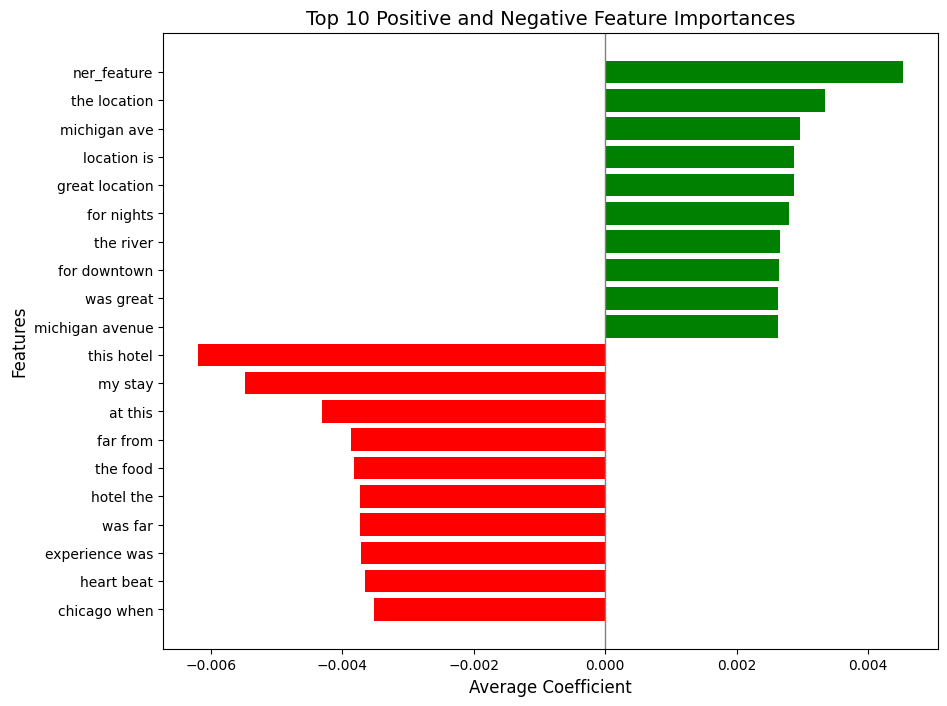

In [103]:
# Separate the top 10 positive and top 10 negative features
top_10_positive = feature_importances[feature_importances['Average Coefficient'] > 0].sort_values(by='Average Coefficient', ascending=False).head(10)
top_10_negative = feature_importances[feature_importances['Average Coefficient'] < 0].sort_values(by='Average Coefficient').head(10)

# Concatenate the top positive and negative features
top_features = pd.concat([top_10_positive, top_10_negative])

# Create a bar plot
plt.figure(figsize=(10, 8))
colors = ['green' if x > 0 else 'red' for x in top_features['Average Coefficient']]
plt.barh(top_features['Feature'], top_features['Average Coefficient'], color=colors)
plt.xlabel('Average Coefficient', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Top 10 Positive and Negative Feature Importances', fontsize=14)
plt.axvline(x=0, color='grey', lw=1)
plt.gca().invert_yaxis()
plt.show()